In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
## Import all the libraries that will be used in this notebook

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer, OneHotEncoder, VectorAssembler, IndexToString
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import *

# MSBA 6330 Homework 7 - Spark MLlib - Danny Moncada

## Part A. Short Answers

1\. Both Scikit-learn and Spark MLlib can run machine learning models, discuss the strengths of each (name two for each package). If you use sources to support your answers, be sure to credit the sources

# Answer:

`scikit-learn` is a Python module that integrates a wide range of machine learning algorithms for supervised and unsupervised problems.  The highlight of this package is its focus on bringing machine learning to non-specialists using a general-purpose high-level language. [JMLR 12, pg. 2826]

<b>Strengths</b>:
<br>
<br>1.  `scikit-learn` avoids using framework code and keeps the number of different objects to a minimum, and instead rely on `numpy` arrays for data containers.  Utilizing a bare-bone design and API helps it integrate seamlessly with other scientific Python libraries like `scipy`.  If you are familiar with both and how they work, then understanding `scikit-learn` is pretty straightfoward.  [JMLR 12, pg. 2827]
<br>
<br>2. `scikit-learn` provides modern implementations of many well known machine learning algorithms, while at the same time maintaining an easy-to-use interface integrated with Python (this is why I love this, <i>integrated with Python!</i>).  Therefore, this answers the need for statistical data analysis by non-specialists in various/numerous industries, as well as in fields outside of computer-science like biology or physics.  [JMLR 12, pg. 2826]

<br>
<br>

`spark MLlib` is Spark’s open-source distributed machine learning library.  It provides efficient functionality for a wide range of learning settings and includes several underlying statistical, optimization, and linear algebra primitives.  `spark MLlib` supports several languages and provides a high-level API that leverages Spark’s rich ecosystem to simplify the development of end-to-end machine learning pipelines.  [JMLR 17, pg. 2]

<b>Strengths</b>:
<br>
<br>1. Multi-language support: Java, Scala, Python, R.
<br>
<br>2. Unified stack: A special purpose machine learning package like `scikit-learn` MAY be better, but the cost of having to switch between different languages or data formats may be prohibitive.  With this one library, you can perform a multitude of different machine learning techniques without having to switch between APIs or programs.  One stop shopping!

<span style="color:blue">

[1] Pedregosa et al. (2011). <i>Scikit-learn: Machine Learning in Python</i> [PDF File]. Retreived August 10, 2019, from Journal of Machine Learning 12: http://www.jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf


[2]  Xiangrui Meng et al.  <i>MLlib: Machine Learning in Apache Spark</i> [PDF File].  Retreived August 10, 2019, from Journal of Machine Learning 17: http://www.jmlr.org/papers/volume17/15-237/15-237.pdf
</span>

## Part B. Analyze Titanic Dataset using pyspark.ml

This is a famous dataset for machine learning. A description of the dataset can be found at [kaggle website](https://www.kaggle.com/c/titanic/data). In the following, we apply the logistic regression model from pyspark.ml package to this dataset. The goal is to predict survival of passages on board titanice, and to use the pipeline and feature tools from pyspark.ml. 

Though the data is small (and does not warrant the use of big data tools such as Spark), we can use it to learn the process of training and apply machine learning models that scale well. 

**In the following, we require you to make sure that your analysis is scalable; that is, all the heavy lifting should be done using distributed computing (collecting a DataFrame and process it using Pandas will not be scalable unless the dataframe is guaranteed to be small). You should assume that you are working with a huge dataset with hundreds of millions of rows. That said, there may be parts of your analysis that results in a DataFrame that is guaranteed to be small enough. For example, the resulf of summary statistics will always be small enough that you can analyze it locally using Python (e.g., Pandas).**

### Step 1: read data from local folder

1\. Load csv data into a data frame
- you should infer schema from the csv file

In [3]:
! head -5 titanic*

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S


In [4]:
titanic_df = sqlCtx.read.format("csv").option("header", "true") \
    .option("inferSchema", "true").load("titanic.csv")

In [5]:
titanic_df.cache()

DataFrame[PassengerId: int, Survived: int, Pclass: int, Name: string, Sex: string, Age: double, SibSp: int, Parch: int, Ticket: string, Fare: double, Cabin: string, Embarked: string]

2\. Verify the schema and first 5 rows of data
- **tip**: using Spark DataFrame's `toPandas()` for nicer display of data.

In [6]:
titanic_df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [7]:
titanic_df.toPandas().head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


### Step 2. Data exploration
the goal of this step is to familiarize yourself with the dataset
- detect data problems
- inform the data engineering steps
- inform the feature selection

3\. Obtain summary statistics on the dataframe, which again will inform our data processing strategies
- pay attention to whether there are missing data
- whether the field appears to be continous or discrete



In [8]:
titanic_df.describe().toPandas().set_index("summary").T

summary,count,mean,stddev,min,max
PassengerId,891,446.0,257.3538420152301,1,891
Survived,891,0.3838383838383838,0.48659245426485753,0,1
Pclass,891,2.308641975308642,0.8360712409770491,1,3
Name,891,None,None,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""","van Melkebeke, Mr. Philemon"
Sex,891,None,None,female,male
Age,714,29.69911764705882,14.526497332334035,0.42,80.0
SibSp,891,0.5230078563411896,1.1027434322934315,0,8
Parch,891,0.38159371492704824,0.8060572211299488,0,6
Ticket,891,260318.54916792738,471609.26868834975,110152,WE/P 5735
Fare,891,32.2042079685746,49.69342859718089,0.0,512.3292


4\. Frequency analysis for categorical columns: for each of the string (except for `name` and `ticket`) and categorical columns (numerical colums except for `Age` and `Fare`), print the count of the 10 most frequent values ordered by descending order of frequency.
- useful for deciding whether the string column can be treated as a categorical variable
- useful for detecting errors, missing values in such columns

*Tip: since we are doing this repeatedly, useful to write a function*

In [9]:
## I removed PassengerId from the analysis as well, it really has no bearing on whether they survived

excluded = ['Name', 'Ticket', 'Age', 'Fare', 'PassengerId']
    
def freq_analysis(df):
    
    output = []
    
    for i in df.columns:
        if i not in excluded:
            output.append(df.groupby(i).count().toPandas().sort_values("count", ascending = False).head(10))
            
    for i in output:
        print(i)
        print()

In [10]:
## Run the function I created above to print the count of the 10 most frequent values ordered by desc

freq_analysis(titanic_df)

   Survived  count
1         0    549
0         1    342

   Pclass  count
1       3    491
0       1    216
2       2    184

      Sex  count
1    male    577
0  female    314

   SibSp  count
6      0    608
0      1    209
5      2     28
3      4     18
1      3     16
4      8      7
2      5      5

   Parch  count
6      0    678
0      1    118
5      2     80
2      3      5
3      5      5
4      4      4
1      6      1

           Cabin  count
45          None    687
31       B96 B98      4
73            G6      4
99   C23 C25 C27      4
15            F2      3
25       C22 C26      3
71          E101      3
103          F33      3
67             D      3
34           D20      2

  Embarked  count
3        S    644
2        C    168
0        Q     77
1     None      2



5\. Histogram for numerical columns: SparkSQL does not have a histogram function, but RDD has one. So one strategy is to convert DataFrame to RDD then call histogram there. The [rdd's histogram function](https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html#histogram) is described here. For your convenience, we have provided a function that takes the histogram function's return values and plot them in a bar chart.

Use RDD's histogram function to analyze the two numerical fields: Age and Fare, and plot the results using the following function. **Also answer the question at the end.**

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def create_hist(rdd_histogram_data,field):
    """Given an RDD.histogram and field name, plot a histogram bar chart"""
    heights = np.array(rdd_histogram_data[1])
    full_bins = rdd_histogram_data[0]
    mid_point_bins = full_bins[:-1]
    widths = [(i - j)*0.8 for i, j in zip(full_bins[:-1], full_bins[1:])]
    bar = plt.bar(mid_point_bins, heights, width=widths, color='b')
    plt.ylabel('Frequency')
    plt.title('Histogram of '+field)  
    return bar

In [12]:
age_hist_rdd = titanic_df.select("Age").rdd.map(lambda r: r.Age).histogram(10)

age_hist_rdd

([0.42,
  8.378,
  16.336000000000002,
  24.294000000000004,
  32.252,
  40.21,
  48.168000000000006,
  56.126000000000005,
  64.084,
  72.042,
  80.0],
 [54, 46, 177, 169, 118, 70, 45, 24, 9, 2])

<BarContainer object of 10 artists>

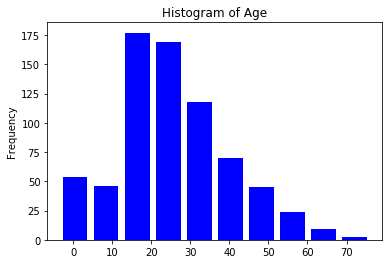

In [13]:
create_hist(age_hist_rdd, "Age")

In [14]:
fare_hist_rdd = titanic_df.select("Fare").rdd.map(lambda r: r.Fare).histogram(10)

fare_hist_rdd

([0.0,
  51.23292,
  102.46584,
  153.69876,
  204.93168,
  256.1646,
  307.39752,
  358.63044,
  409.86336,
  461.09628,
  512.3292],
 [732, 106, 31, 2, 11, 6, 0, 0, 0, 3])

<BarContainer object of 10 artists>

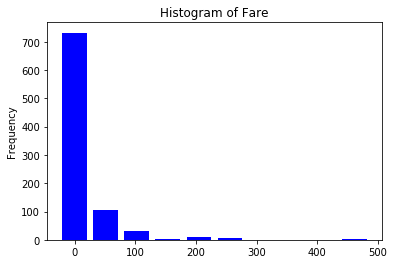

In [15]:
create_hist(fare_hist_rdd, "Fare")

**Question**: Why haven't we suggested you to Pandas' convenient `hist` function to obtain the histogram?

# Answer:

Spark DataFrames are much different compared to Pandas DataFrames; you cannot exactly transform a Spark DataFrame to a Pandas DataFrame.  In the exercise above, the function that actually generates the histogram converts the two RDDs, Age and Fare, into `numpy` arrays.  It then dynamically builds out the bins for the given distribution, and plots them out.  To do this transformation with `hist`, you would need it to already be in a dataframe format and then assign your own bins, like below.  You would only want to do this method for a quick visualization of the distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f62133862b0>]],
      dtype=object)

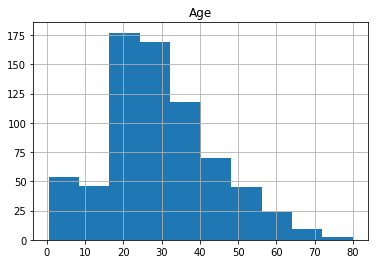

In [16]:
titanic_df.select("Age").toPandas().hist(bins = 10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f62132f0a20>]],
      dtype=object)

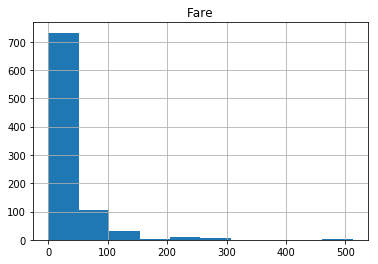

In [17]:
titanic_df.select("Fare").toPandas().hist(bins = 10)

### Step 3. Some feature engineering
the goal of this step is to do necessary feature engineering. Note that currently `pyspark.ml.features` provide a few feature engineering tools such as:
- stringindexer: for convert string labels into numerical labels (0, 1,...), ordered by label frequencies
- one-hot-encoder: mapping a column of category indices to a column of binary vectors.
- vector assembler: merges multiple columns into one vector columns needed for most algorithms

here we will focus on
- dealing with missing values
- creating new columns
- converting data types

6\. Create a new data frame by selecting all feature columns you plan to use, plus `Survived` and convert all numerical columns into double type. The reason we convert all numeric types to doubles is because it seems that PySpark does not work well with other numerical types. Then show the first 10 rows

**hint**: one way to convert data types is through PySpark's `.cast()` method for column expressions


In [18]:
## Create the featureA_df, my alpha version of the feature dataframe.  It will go through several changes/transformations so I give it Alpha
## All numeric type columns are converted to double.  All string stay the same

featureA_df = titanic_df.select(col("Survived"), col("Embarked"), col("Sex"), col("Pclass").cast("double"), col("SibSp").cast("double"), \
                              col("Age").cast("double"), col("Fare").cast("double"))

In [19]:
## Show the first 10 rows

featureA_df.show(10)

+--------+--------+------+------+-----+----+-------+
|Survived|Embarked|   Sex|Pclass|SibSp| Age|   Fare|
+--------+--------+------+------+-----+----+-------+
|       0|       S|  male|   3.0|  1.0|22.0|   7.25|
|       1|       C|female|   1.0|  1.0|38.0|71.2833|
|       1|       S|female|   3.0|  0.0|26.0|  7.925|
|       1|       S|female|   1.0|  1.0|35.0|   53.1|
|       0|       S|  male|   3.0|  0.0|35.0|   8.05|
|       0|       Q|  male|   3.0|  0.0|null| 8.4583|
|       0|       S|  male|   1.0|  0.0|54.0|51.8625|
|       0|       S|  male|   3.0|  3.0| 2.0| 21.075|
|       1|       S|female|   3.0|  0.0|27.0|11.1333|
|       1|       C|female|   2.0|  1.0|14.0|30.0708|
+--------+--------+------+------+-----+----+-------+
only showing top 10 rows



In [20]:
## Show the schema to confirm the datatypes were converted successfully.

featureA_df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Pclass: double (nullable = true)
 |-- SibSp: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Fare: double (nullable = true)



7\. From the summary statistics, we notice that there are missing values in the `Age` and `Embarked` columns. One way of dealing with this is to drop rows with missing values. Alternatively, we may use a mean replacement strategy. 

- Replace the null values in the `Age` column with the mean age. 
- Create a new binary indicator column **AgeNA**, indicated whether the `Age` value was imputed (**hint**: you may use isnull() function from pyspark.sql). This column needs to be a double type. 
- Drop the remaining rows with missing values (i.e., in the `Embarked` column)


In [21]:
## I re-initialize the DataFrame in case I screw up any of the transformation below, I can keep it all in this cell and re-run the first line
## But I debugged this thoroughly and had no issues after finalizing the program

feature_df = featureA_df

### Creating a new feature_df, first I need to create the AgeNA Column since I will fill in values after the fact.

feature_df = feature_df.select("*", when(feature_df.Age.isNull(), 1.0).otherwise(0.0).alias("AgeNA"))

### Replace any Age that is null with the average age, which was a simple calculation that I saved as a variable

avg_age = feature_df.agg(avg("Age")).collect()[0][0]
feature_df = feature_df.withColumn("Age", when(feature_df.Age.isNull(), avg_age).otherwise(feature_df.Age))

## drop any remaining rows with NA values and we're done!
feature_df = feature_df.dropna()

8\. Verify the new DataFrame by printing its schema and descriptive statistics (to ascertain there are no missing values).

In [22]:
feature_df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Pclass: double (nullable = true)
 |-- SibSp: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Fare: double (nullable = true)
 |-- AgeNA: double (nullable = false)



In [23]:
## No missing values, all 889

feature_df.describe().toPandas().set_index("summary").T

summary,count,mean,stddev,min,max
Survived,889,0.38245219347581555,0.48625968831477334,0,1
Embarked,889,None,None,C,S
Sex,889,None,None,female,male
Pclass,889,2.3115860517435323,0.8346997785705753,1.0,3.0
SibSp,889,0.5241844769403825,1.103704875596923,0.0,8.0
Age,889,29.653446370674192,12.968366309252314,0.42,80.0
Fare,889,32.09668087739029,49.69750431670795,0.0,512.3292
AgeNA,889,0.19910011248593926,0.3995482811002537,0.0,1.0


### Step 4: Indexers and Encoders for string/categorical columns (for use with Pipeline)

String columns cannot be directly in with some of the models such as LogisticRegression. Neither are categorical columns. Our strategy is to convert string and categorical variables into a series of binary dummies. Fortunately, these steps are already provided as part of pyspark.ml.features. 

To convert indexed categorical values into a vector of binary indicators, we can leverage `OneHotEncoder`

Finally, we need to assemble a vector column with all the numerical features. This is achieved by `VectorAssembler`


Click on each below to familiar with them if you need further information.
- [StringIndexer](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.StringIndexer): for convert string labels into numerical labels (0, 1,...), ordered by label frequencies
- [OneHotEncoderEstimator](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.OneHotEncoderEstimator): mapping a column of category indices to a column of binary vectors (the least frequent one will be dropped by default).
- [VectorAssembler](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.VectorAssembler): merges multiple columns into one vector columns needed for most algorithms

9\. Create string indexers for string features, and OneHotEncoder estimators for indexed string values:
- call them `[field]_indexer`, `[field]_encoder` respectively (e.g. gender_indexer, gender_encoder)

- You should test them on the data to make sure that they work as intended.

In [24]:
## Create string indexers for the string features & Survived column

embark_indexer = StringIndexer(inputCol = 'Embarked', outputCol = 'indexed_Embarked')
gender_indexer = StringIndexer(inputCol = 'Sex', outputCol = 'indexed_Sex')

survive_indexer = StringIndexer(inputCol = "Survived", outputCol = "indexed_Survived")

In [25]:
## Create encoders for indexed columns to vectorize them

gender_encoder = OneHotEncoder(inputCol = "indexed_Sex", outputCol = "vectorized_Sex")
embark_encoder = OneHotEncoder(inputCol = "indexed_Embarked", outputCol = "vectorized_Embarked")

In [26]:
## Testing my StringIndexers & OneHotEncoders
## Fit the indexers first, then transform
test = embark_indexer.fit(feature_df).transform(feature_df)
test = gender_indexer.fit(test).transform(test)

test = survive_indexer.fit(test).transform(test)

## Transform for the final time to get the vectorized columns
test = embark_encoder.transform(test)
test = gender_encoder.transform(test)

test.show(8)

print("Looks like it's working as expected!")

+--------+--------+------+------+-----+-----------------+-------+-----+----------------+-----------+----------------+-------------------+--------------+
|Survived|Embarked|   Sex|Pclass|SibSp|              Age|   Fare|AgeNA|indexed_Embarked|indexed_Sex|indexed_Survived|vectorized_Embarked|vectorized_Sex|
+--------+--------+------+------+-----+-----------------+-------+-----+----------------+-----------+----------------+-------------------+--------------+
|       0|       S|  male|   3.0|  1.0|             22.0|   7.25|  0.0|             0.0|        0.0|             0.0|      (2,[0],[1.0])| (1,[0],[1.0])|
|       1|       C|female|   1.0|  1.0|             38.0|71.2833|  0.0|             1.0|        1.0|             1.0|      (2,[1],[1.0])|     (1,[],[])|
|       1|       S|female|   3.0|  0.0|             26.0|  7.925|  0.0|             0.0|        1.0|             1.0|      (2,[0],[1.0])|     (1,[],[])|
|       1|       S|female|   1.0|  1.0|             35.0|   53.1|  0.0|           

### Step 5: Assemble feature columns into a feature vector (for use with the pipeline)
10\. use `VectorAssember` to assemble all features into one column, we shall the new column `features`

In [27]:
## Put all of my features columns into a variable, in case I want to add/remove/change them later on, but I settled on these

featureCols = ["Pclass", "SibSp", "Age", "Fare", "AgeNA", "vectorized_Embarked", "vectorized_Sex"]

## Build my VectorAssembler and create my features column
va = VectorAssembler(inputCols = featureCols, outputCol = "features")

In [28]:
## Testing to make sure VectorAssembler works
## Show the first 8 rows to confirm transformation will work

vectorized = va.transform(test)

vectorized.show(8)

+--------+--------+------+------+-----+-----------------+-------+-----+----------------+-----------+----------------+-------------------+--------------+--------------------+
|Survived|Embarked|   Sex|Pclass|SibSp|              Age|   Fare|AgeNA|indexed_Embarked|indexed_Sex|indexed_Survived|vectorized_Embarked|vectorized_Sex|            features|
+--------+--------+------+------+-----+-----------------+-------+-----+----------------+-----------+----------------+-------------------+--------------+--------------------+
|       0|       S|  male|   3.0|  1.0|             22.0|   7.25|  0.0|             0.0|        0.0|             0.0|      (2,[0],[1.0])| (1,[0],[1.0])|[3.0,1.0,22.0,7.2...|
|       1|       C|female|   1.0|  1.0|             38.0|71.2833|  0.0|             1.0|        1.0|             1.0|      (2,[1],[1.0])|     (1,[],[])|[1.0,1.0,38.0,71....|
|       1|       S|female|   3.0|  0.0|             26.0|  7.925|  0.0|             0.0|        1.0|             1.0|      (2,[0],

### Step 6: Create the LogisticRegression model (for use with the pipeline)
- the documentation of LogisticRegression from pyspark.ml can be [found here](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.LogisticRegression).

11\. Create the LogisticRegression model

In [29]:
## Build the LR model using my features column and my indexed Survived column

lr = LogisticRegression(featuresCol = "features", labelCol = "indexed_Survived")

### Step 7. Assemble Pipelines 
12\. put together the stages of the pipeline, with the last step being the logisistic regression

In [30]:
## Build my pipeline and get ready to feed it to my LR model

pl = Pipeline(stages = [embark_indexer, gender_indexer, survive_indexer, gender_encoder, embark_encoder, va, lr])

### Step 8: prepare training and test datasets
13\. Please use a 70-30 random split here for training and testing data sets respectively, then verify their sizes

In [31]:
## Split my feature_df 70/30 for my training and testing data sets.

train, test = feature_df.randomSplit([0.7, 0.3])

In [32]:
## Confirm their sizes after the split and make sure they add up to the original dataframe

print("The train DataFrame has {} number of rows.".format(train.count()))
print()

print("The test DataFrame has {} number of rows.".format(test.count()))
print()

print("There are {} total number of rows, matching the {} number of rows from the original DataFrame.".format(train.count() + test.count(), feature_df.count()))

The train DataFrame has 627 number of rows.

The test DataFrame has 262 number of rows.

There are 889 total number of rows, matching the 889 number of rows from the original DataFrame.


### Step 9: Fit the model and use it on the test dataset

14\. Fit the model using the predefined pipeline on the training set

In [33]:
## Fit the model using my cool Pipeline

pipelineModel = pl.fit(train)

15\. Use the fitted model to obtain predictions on the test set

In [34]:
## Make my predictions on the test set

predictions = pipelineModel.transform(test)

16\. Obtain the logistic regression model, and report its coefficients
- you can easily obtain the model for each stage of the pipeline using **.stages[index]**

In [35]:
### Get the coefficients and display them

pipelineModel.stages[-1].coefficients

DenseVector([-1.0032, -0.5, -0.0507, 0.0049, -0.3729, -0.4947, -0.1556, -2.6339])

17\. Interpret the first two coefficients (optional but encouraged)

# Answer:

I have `PassengerClass` and `SibSp` (# of siblings / spouses aboard the Titanic) as my first two metrics in the features column.
<br>
<br>
The first coefficient is -1.0032.  Since we see that there is a negative correlation between PassengerClass to Survival Rate, what this is telling us is that the smaller the PassengerClass ( < 1), the more likely the passenger was able to survive; our Logistic Regression model is telling us that if you were a passenger in 1st class (1.0), you were more likely to survive than passengers in 3rd class (3.0).  This logically makes sense, since 1st class passengers were likely closer to the top of the ship when it sank.
<br>
<br>
The second coefficient is -0.5.  Similarly, there is a negative correlation between the number of siblings and spouses the passenger had with them compared to Survival Rate; our Logistic Regression model is telling us is that the less siblings or spouses had aboard the ship, the more likely they were to survive.  Again, this conceptually/logically makes sense, since those passengers who only had to worry about their own well being likely would have fled, and many of those husbands with women and children were likely to have died to stay behind.

### Step 10. Evaluate model performance

It is useful to see how is the results DataFrame after applying the model.

18\. print first 5 rows of the results

In [47]:
predictions.limit(5).toPandas()

,Survived,Embarked,Sex,Pclass,SibSp,Age,Fare,AgeNA,indexed_Embarked,indexed_Sex,indexed_Survived,vectorized_Sex,vectorized_Embarked,features,rawPrediction,probability,prediction
0,0,C,female,3.0,0.0,17.000000,14.4583,0.0,1.0,1.0,0.0,(0.0),"(0.0, 1.0)","(3.0, 0.0, 17.0, 14.4583, 0.0, 0.0, 1.0, 0.0)","[-1.557613799281047, 1.557613799281047]","[0.1739893179761806, 0.8260106820238194]",1.0
1,0,C,female,3.0,0.0,29.699118,15.2458,1.0,1.0,1.0,0.0,(0.0),"(0.0, 1.0)","[3.0, 0.0, 29.69911764705882, 15.2458, 1.0, 0....","[-0.5452783751667569, 0.5452783751667569]","[0.3669605542328859, 0.6330394457671141]",1.0
2,0,C,male,1.0,0.0,24.000000,79.2000,0.0,1.0,0.0,0.0,(1.0),"(0.0, 1.0)","[1.0, 0.0, 24.0, 79.2, 0.0, 0.0, 1.0, 1.0]","[-0.8927028577509448, 0.8927028577509448]","[0.29055236755718555, 0.7094476324428145]",1.0
3,0,C,male,1.0,0.0,24.000000,247.5208,0.0,1.0,0.0,0.0,(1.0),"(0.0, 1.0)","[1.0, 0.0, 24.0, 247.5208, 0.0, 0.0, 1.0, 1.0]","[-1.7170995127360196, 1.7170995127360196]","[0.15224514208793857, 0.8477548579120614]",1.0
4,0,C,male,1.0,0.0,27.000000,211.5000,0.0,1.0,0.0,0.0,(1.0),"(0.0, 1.0)","[1.0, 0.0, 27.0, 211.5, 0.0, 0.0, 1.0, 1.0]","[-1.388713289766545, 1.388713289766545]","[0.19961325225967042, 0.8003867477403296]",1.0


19\. Obtain the AUC, f1, Accuracy, Weighted Precision, Weighted Recall for the model 

**tip**: we will report the same metrics below a few times. It may be handy for you to create a function for the calculation of the five metrics.

In [37]:
## Create a function that calculates the five requested metrics 

def reporting_metrics(prediction_df, label, prediction):
    
    AoC_eval = BinaryClassificationEvaluator(labelCol = label, rawPredictionCol = prediction, metricName = "areaUnderROC")
    AoC = AoC_eval.evaluate(prediction_df)
    print("AreaUnderROC = %s" % AoC)
    
    f1_eval = MulticlassClassificationEvaluator(labelCol = label, predictionCol = prediction, metricName = "f1")
    f1 = f1_eval.evaluate(prediction_df)
    print("f1 = %s" % f1)
    
    acc_eval = MulticlassClassificationEvaluator(labelCol = label, predictionCol = prediction, metricName = "accuracy")
    acc = acc_eval.evaluate(prediction_df)
    print("Accuracy = %s" % acc)
    
    wp_eval = MulticlassClassificationEvaluator(labelCol= label, predictionCol = prediction, metricName = "weightedPrecision")
    wp = wp_eval.evaluate(prediction_df)
    print("weightedPrecision = %s" % wp)
    
    wr_eval = MulticlassClassificationEvaluator(labelCol= label, predictionCol = prediction, metricName = "weightedRecall")
    wr = wr_eval.evaluate(prediction_df)
    print("weightedRecall = %s" % wr)

In [38]:
## Run function to get the metrics based on the prediction, and have the results printed

reporting_metrics(predictions, "indexed_Survived", "prediction")

AreaUnderROC = 0.7880974695407685
f1 = 0.8046916266012225
Accuracy = 0.8053435114503816
weightedPrecision = 0.8042602496577647
weightedRecall = 0.8053435114503816


20\. Fit a RandomForest model, obtain predictions, and report same the performance metrics as above

In [39]:
## Create a RForest model - I hard coded a maxDept and numTrees different from the default to demonstrate the performance tuning aspect

rf = RandomForestClassifier(labelCol = "indexed_Survived", featuresCol = "features", maxDepth = 3, numTrees = 25)

## Create the RForest Pipeline and stage it as variable rf_pl
rf_pl = Pipeline(stages = [embark_indexer, gender_indexer, survive_indexer, gender_encoder, embark_encoder, va, rf])

## Fit the RForest model on the train DataFrame
rf_model = rf_pl.fit(train)

## Make the predictions based on the fitted RForest model
rf_predictions = rf_model.transform(test)

## Show the final predictions DataFrame for the RForest model
rf_predictions.select("prediction", "Survived", "features").toPandas().head(8)

,prediction,Survived,features
0,1.0,0,"(3.0, 0.0, 17.0, 14.4583, 0.0, 0.0, 1.0, 0.0)"
1,1.0,0,"[3.0, 0.0, 29.69911764705882, 15.2458, 1.0, 0...."
2,0.0,0,"[1.0, 0.0, 24.0, 79.2, 0.0, 0.0, 1.0, 1.0]"
3,0.0,0,"[1.0, 0.0, 24.0, 247.5208, 0.0, 0.0, 1.0, 1.0]"
4,0.0,0,"[1.0, 0.0, 27.0, 211.5, 0.0, 0.0, 1.0, 1.0]"
5,0.0,0,"[1.0, 0.0, 56.0, 30.6958, 0.0, 0.0, 1.0, 1.0]"
6,0.0,0,"[1.0, 0.0, 58.0, 29.7, 0.0, 0.0, 1.0, 1.0]"
7,0.0,0,"[1.0, 0.0, 65.0, 61.9792, 0.0, 0.0, 1.0, 1.0]"


In [40]:
## Run the reporting metrics function to see how the RForest model performed.  It should be SLIGHTLY better than our Logistic Regression model.

reporting_metrics(rf_predictions, "indexed_Survived", "prediction")

AreaUnderROC = 0.7908153701968135
f1 = 0.8139682735906119
Accuracy = 0.816793893129771
weightedPrecision = 0.8148577169255591
weightedRecall = 0.8167938931297709


21\. RandomForest has a few parameters can be further tuned. We are considering among these:

- maxDepth: {3, 5}
- numTrees: {15, 20, 25}


Use CrossValidator (3 folds) to find the best parameter combination. Obtain predictions using the best model (using areaUnderROC as a metric), and report same the performance metrics as above.

In [41]:
## Create the ParamGrid to test the other combinations as requested.  We will test a maxDepth of 3 and 5, and numTrees of 15, 20, 25
paramGrid = ParamGridBuilder().addGrid(rf.maxDepth,[3,5]).addGrid(rf.numTrees, [15, 20, 25]).build()

## Build an evaluator to test the RForest Classifier using areaUnderROC as the test metric
evaluator = BinaryClassificationEvaluator(labelCol = 'indexed_Survived', rawPredictionCol = 'prediction', metricName='areaUnderROC')

## Build the cross validator based on the RForest Pipeline above, the ParamGrid, the evaluation metrics, and 3 folds
crossval = CrossValidator(estimator = rf_pl, estimatorParamMaps = paramGrid, evaluator = evaluator, numFolds = 3)

In [42]:
## Run the CrossValidator on the train dataset and create a new output rf_model_2
rf_model_2 = crossval.fit(train)

## Transform the test data set and try to do a better job predicting!
transformed_data = rf_model_2.transform(test)

## Show a few lines of the final transformed test data to see if it worked
transformed_data.toPandas().head(3)

,Survived,Embarked,Sex,Pclass,SibSp,Age,Fare,AgeNA,indexed_Embarked,indexed_Sex,indexed_Survived,vectorized_Sex,vectorized_Embarked,features,rawPrediction,probability,prediction
0,0,C,female,3.0,0.0,17.000000,14.4583,0.0,1.0,1.0,0.0,(0.0),"(0.0, 1.0)","(3.0, 0.0, 17.0, 14.4583, 0.0, 0.0, 1.0, 0.0)","[10.244450379909571, 14.755549620090433]","[0.4097780151963828, 0.5902219848036172]",1.0
1,0,C,female,3.0,0.0,29.699118,15.2458,1.0,1.0,1.0,0.0,(0.0),"(0.0, 1.0)","[3.0, 0.0, 29.69911764705882, 15.2458, 1.0, 0....","[8.807304307249915, 16.192695692750085]","[0.3522921722899966, 0.6477078277100035]",1.0
2,0,C,male,1.0,0.0,24.000000,79.2000,0.0,1.0,0.0,0.0,(1.0),"(0.0, 1.0)","[1.0, 0.0, 24.0, 79.2, 0.0, 0.0, 1.0, 1.0]","[15.759949003040537, 9.240050996959466]","[0.6303979601216214, 0.3696020398783786]",0.0


In [43]:
## Run function to get the metrics based on the improved RF prediction, and have the results printed

reporting_metrics(transformed_data, "indexed_Survived", "prediction")

AreaUnderROC = 0.7892845985629491
f1 = 0.8215881857839298
Accuracy = 0.8282442748091603
weightedPrecision = 0.8325688585331013
weightedRecall = 0.8282442748091603


In [44]:
## Much better results this time!  What an improvement!

22\. What are the parameters selected by the CrossValidator?

**tip**: 
- CrossValidator's `bestModel` stores the best model
- You can call the best random forest model's `explainParam(parametername)` to see the value of a given parameter


In [45]:
## Select the best model and just print out the winner!
best_model = rf_model_2.bestModel.stages[-1]

print(best_model)

RandomForestClassificationModel (uid=RandomForestClassifier_1bd815745ac8) with 25 trees


In [46]:
## Display the selected parameters chosen by the CrossValidator

print("The CrossValidator selected {} numTrees param for the best random forest model.".format(best_model.explainParam("numTrees")[-3:-1]))

print()

print("The CrossValidator selected {} maxDepth param for the best random forest model.".format(best_model.explainParam("numTrees")[-2]))

The CrossValidator selected 25 numTrees param for the best random forest model.

The CrossValidator selected 5 maxDepth param for the best random forest model.
